In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from google.colab import drive

In [4]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Data1.xlsx'
df = pd.read_excel(file_path)
df = df.drop(["No."],axis = 1)
data_cleaned = df.dropna()
display(data_cleaned)

Mounted at /content/drive


,Tradevalue,Interest,CPI,GDPTW,GDPID,Exchangerate_TW,Exchangerate_ID
0,1043.44,4.543333,81.240000,81139,135355.256125,30.74,7483.333333
1,1254.46,4.670000,81.673333,81801,119275.774773,30.68,8443.333333
2,1236.55,4.750000,81.866667,83514,118987.521626,31.07,8670.000000
3,1214.16,4.710000,82.910000,84271,111509.035986,32.45,9517.500000
4,948.45,4.380000,81.713333,77571,106490.601314,32.53,9895.000000
...,...,...,...,...,...,...,...
91,3287.84,1.670000,103.723333,184142,190205.871091,31.37,15670.000000
92,2631.34,1.793333,104.363333,180361,199728.169480,30.40,15105.000000
93,2623.53,1.880000,105.103333,185510,204896.275645,30.71,14915.333333
94,2743.45,1.880000,105.876667,191900,202499.100288,31.69,15282.666667


In [5]:
# Separate the dependent (Tradevalue) and independent variables
dependent_variable = 'Tradevalue'
X = data_cleaned.drop(columns=[dependent_variable])
y = data_cleaned[dependent_variable]

# Normalize the data using Min-Max Scaler (range 0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled data back to DataFrame for clarity
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled_df = pd.DataFrame(y_scaled, columns=[dependent_variable])

# Display normalized data for verification
X_scaled_df.head(), y_scaled_df.head()

(   Interest       CPI     GDPTW     GDPID  Exchangerate_TW  Exchangerate_ID
 0  0.942910  0.000654  0.072240  0.351938         0.402778         0.000000
 1  0.977901  0.017659  0.077154  0.216892         0.394444         0.117264
 2  1.000000  0.025245  0.089870  0.214471         0.448611         0.144951
 3  0.988950  0.066187  0.095489  0.151661         0.640278         0.248473
 4  0.897790  0.019228  0.045755  0.109513         0.651389         0.294585,
    Tradevalue
 0    0.068647
 1    0.130893
 2    0.125610
 3    0.119006
 4    0.040627)

In [6]:
# Splitting the data into training (90%) and testing (10%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_scaled_df, test_size=0.1, random_state=42
)

# Display the shapes of the splits for verification
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((86, 6), (10, 6), (86, 1), (10, 1))

In [7]:
## MODEL 1
# Reshape the data to fit LSTM requirements
X_train_reshaped = np.expand_dims(X_train.values, axis=-1)
X_test_reshaped = np.expand_dims(X_test.values, axis=-1)

# Build the LSTM model with Conv1D
model = Sequential()

# Conv1D layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.2))

# Flatten the output of Conv1D before feeding it to LSTM if needed
model.add(LSTM(128, activation='relu', return_sequences=True))  # Return sequences for stacking LSTMs
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(64, activation='relu', return_sequences=False))  # Final LSTM layer
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(
    X_train_reshaped, y_train.values,
    validation_data=(X_test_reshaped, y_test.values),
    epochs=3000,
    batch_size=32,
    verbose=1
)

# Save the training history for further analysis
training_history = history.history

"Model training completed successfully."

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


串流輸出內容已截斷至最後 5000 行。
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 502/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 503/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 504/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 505/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0074 - val_loss: 0.0011
Epoch 506/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 507/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 508/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 509/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 510/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 511/3000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 512/3000
3/3 ━━━━━━━━━━━━━━━━━━

'Model training completed successfully.'

In [ ]:
## MODEL 2
# Reshape the data to fit LSTM requirements
X_train_reshaped = np.expand_dims(X_train.values, axis=-1)
X_test_reshaped = np.expand_dims(X_test.values, axis=-1)

# Build the LSTM model with Conv1D
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    LSTM(50, return_sequences=False),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(
    X_train_reshaped, y_train.values,
    validation_data=(X_test_reshaped, y_test.values),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Save the training history for further analysis
training_history = history.history

"Model training completed successfully."

In [8]:
# Make predictions using the trained model
y_pred = model.predict(X_test_reshaped)

# Convert predictions to a DataFrame for readability
y_test_predictions = pd.DataFrame(y_pred, columns=['Predicted Tradevalue'])

# Combine actual and predicted values for comparison
y_test_actual = y_test.reset_index(drop=True)
y_test_comparison = pd.concat([y_test_actual, y_test_predictions], axis=1)
y_test_comparison.columns = ['Actual Tradevalue', 'Predicted Tradevalue']

# Display the comparison DataFrame
print(y_test_comparison)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
   Actual Tradevalue  Predicted Tradevalue
0           0.262102              0.349596
1           0.344330              0.391281
2           0.350814              0.365605
3           0.570112              0.483839
4           0.576710              0.673169
5           0.300260              0.447332
6           0.343867              0.324985
7           0.521573              0.515812
8           0.068647              0.123079
9           0.080856              0.080160


In [9]:
# Reverse transform the scaled 'Tradevalue' data to the original scale
y_test_original = scaler.inverse_transform(y_test.values)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Calculate the Mean Squared Error (MSE) score
mse_score = mean_squared_error(y_test_original, y_pred_original)

# Combine original and predicted values for verification
y_test_comparison_original = pd.DataFrame({
    'Actual Tradevalue (Original Scale)': y_test_original.flatten(),
    'Predicted Tradevalue (Original Scale)': y_pred_original.flatten()
})

# Display the comparison DataFrame and MSE score
y_test_comparison_original, mse_score

(   Actual Tradevalue (Original Scale)  Predicted Tradevalue (Original Scale)
 0                             1699.27                            1995.880371
 1                             1978.03                            2137.198242
 2                             2000.01                            2050.152588
 3                             2743.45                            2450.978760
 4                             2765.82                            3092.823242
 5                             1828.63                            2327.215576
 6                             1976.46                            1912.449219
 7                             2578.90                            2559.369873
 8                             1043.44                            1227.970215
 9                             1084.83                            1082.467896,
 59542.04299167635)

In [10]:
# Calculate the mean of the actual Tradevalue on the original scale
mean_tradevalue = np.mean(y_test_original)

# Convert MSE to RMSE
rmse = np.sqrt(mse_score)

# Calculate the percentage error
percentage_error = (rmse / mean_tradevalue) * 100

mean_tradevalue, rmse, percentage_error

(1969.8839999999996, 244.01238286545285, 12.38714476920737)

In [11]:
# Calculate R² (coefficient of determination)
r2 = r2_score(y_test_original, y_pred_original)
r2

0.821657783019305

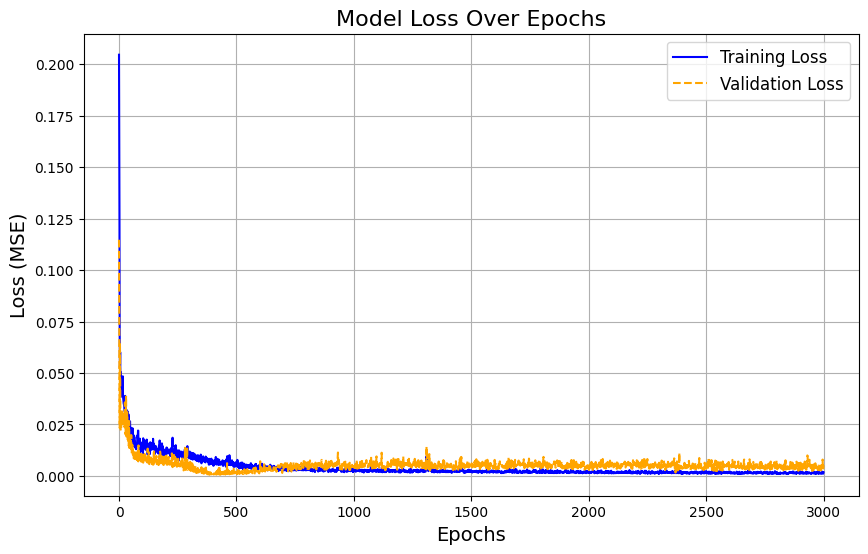

In [20]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', linestyle='--', color='orange')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()